In [0]:
import os
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, isnan, when, count, regexp_extract, split, col, lower, regexp_replace
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType, DoubleType
import re
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StringType, MapType
from pyspark.sql import Window
from sklearn.metrics import confusion_matrix
import numpy as np
from itertools import chain
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler, Normalizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model, PipelineModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
## Setting up file directories to save small data and associated plots
CSV_DIR = "../../data/csv"
PLOT_DIR = "../../data/plots"

## Analysis 1 - Predicting Severity of Reddit Comments

In [0]:
## Reading in ER diagnoses sentiment data and adding length column
sentiment_df = spark.read.parquet('/FileStore/sentiment_ems')
sentiment_df = sentiment_df.withColumnRenamed("col","sentiment")
sentiment_df = sentiment_df.withColumn("length", f.length(col('body')))

In [0]:
## Taking the ems_topic and grouping them into 3 labels based on appropriate next action
## THESE ARE THE LABELS FOR ML MODEL: ER, seek doctor, monitor
ems_topics = ['digestive tract', 'upper respiratory infection', 'allergy to narcotic', 'allergy to antibiotic', 'allergy to drugs', 'allergy to penicillin', 'anemia', 'anxiety', 'atherosclerosis', 'coronary artery heart disease', 'chest pain', 'chronic obstructive pulmonary disease', 'constipation', 'exposure to COVID-19', 'cough', 'COVID-19', 'dehydration', 'diarrhea', 'dizziness', 'immunization', 'stomach pain', 'hypertension', 'fever', 'gastro-esophageal reflux disease', 'headache', 'heart failure', 'homelessness', 'hyperlipidemia', 'hypothyroidism', 'anticoagulants', 'aspirin', 'insulin', 'hypoglycemic', 'lower back pain', 'depression', 'nausea', 'nausea with vomiting', 'addiction to nicotine', 'addiction', 'obesity', 'other chest pain', 'other chronic pain', 'drug therapy', 'postprocedural', 'nicotine dependence', 'transient ischemic attack', 'hypercholesterolemia', 'shortness of breath', 'collapse', 'tachycardia', 'type 2 diabetes with chronic kidney disease', 'type 2 diabetes', 'abdominal pain', 'uncomplicated asthma', 'atrial fibrillation', 'head injury', 'urinary tract infection', 'unspecified vomiting', 'weakness']

ER = ['allergy to antibiotic', 'abdominal pain', 'chest pain','allergy to drugs', 'allergy to penicillin', 'coronary artery heart disease', 'heart failure', 'transient ischemic attack', 'collapse', 'tachycardia', 'type 2 diabetes with chronic kidney disease', 'head injury']
seek_doctor = ['digestive tract', 'shortness of breath', 'chronic obstructive pulmonary disease', 'upper respiratory infection', 'anxiety', 'atherosclerosis', 'immunization', 'stomach pain', 'hypertension', 'insulin', 'hypoglycemic', 'depression', 'addiction to nicotine', 'addiction', 'hypercholesterolemia', 'type 2 diabetes', 'uncomplicated asthma', 'atrial fibrillation', 'urinary tract infection', 'postprocedural', 'drug therapy', 'nauseau with vomiting', 'hypothyroidism']
monitor = [i for i in ems_topics if i not in ER + seek_doctor]
monitor

Out[105]: ['allergy to narcotic',
 'anemia',
 'constipation',
 'exposure to COVID-19',
 'cough',
 'COVID-19',
 'dehydration',
 'diarrhea',
 'dizziness',
 'fever',
 'gastro-esophageal reflux disease',
 'headache',
 'homelessness',
 'hyperlipidemia',
 'anticoagulants',
 'aspirin',
 'lower back pain',
 'nausea',
 'nausea with vomiting',
 'obesity',
 'other chest pain',
 'other chronic pain',
 'nicotine dependence',
 'unspecified vomiting',
 'weakness']

In [0]:
## Grouping the individual topics into 6 major categories - this will be one of the features
stomach = ['digestive tract', 'gastro-esophageal reflux disease', 'stomach pain', 'abdominal pain', 'diarrhea', 'constipation', 'nausea with vomiting', 'unspecified vomiting']
substance = ['addiction to nicotine', 'addiction', 'nicotine dependence', 'allergy to narcotic', 'allergy to antibiotic', 'allergy to drugs', 'allergy to penicillin', 'insulin', 'aspirin']
chest = ['upper respiratory infection', 'coronary artery heart disease', 'chest pain', 'chronic obstructive pulmonary disease', 'heart failure', 'other chest pain', 'shortness of breath', 'cough', 'atrial fibrillation', 'uncomplicated asthma', 'tachycardia']
chronic = ['atherosclerosis', 'hypertension', 'hyperlipidemia','hypothyroidism', 'hypoglycemic', 'other chronic pain', 'hypercholesterolemia', 'type 2 diabetes', 'type 2 diabetes with chronic kidney disease'] 
mental = ['anxiety', 'depression', 'nausea', 'dizziness', 'headache']
other = [i for i in ems_topics if i not in stomach + substance + chest + mental + chronic]

In [0]:
## Adding general topics and the labels to the data
topics = sentiment_df.withColumn("gen_topic", when(col('ems_topic').isin(stomach), "stomach")
                                             .when(col('ems_topic').isin(substance), "substance")
                                             .when(col('ems_topic').isin(chest), "chest")
                                             .when(col('ems_topic').isin(chronic), "chronic")
                                             .when(col('ems_topic').isin(mental), "mental")
                                             .otherwise('other'))
labeled_df = topics.withColumn('label', when(col('ems_topic').isin(ER), "ER")
                                        .when(col('ems_topic').isin(seek_doctor), "seek doctor")
                                        .otherwise("monitor"))
## Displaying a label count - labels are unbalanced with ER being by far the smallest category
labeled_df.groupBy(col('label')).count().show()

+-----------+-----+
|      label|count|
+-----------+-----+
|    monitor|45709|
|seek doctor|39120|
|         ER| 9568|
+-----------+-----+



In [0]:
## Computing class weights to balance the model

y_collect = labeled_df.groupBy(col('label')).count().collect()
unique_y = [x["label"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)

{'monitor': 0.6883910535489, 'seek doctor': 0.8043370824812542, 'ER': 3.288635730211817}


In [0]:
## Mapping the class weights to the dataframe

mapping_expr = f.create_map([f.lit(x) for x in chain(*class_weights_spark.items())])

labeled_df = labeled_df.withColumn("weight", mapping_expr.getItem(col("label")))
labeled_df.show()

/databricks/spark/python/pyspark/sql/column.py:423: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(
+--------------------+------------+---------+------------+---------+------+---------+-----------+------------------+
|                body|retrieved_on|subreddit|   ems_topic|sentiment|length|gen_topic|      label|            weight|
+--------------------+------------+---------+------------+---------+------+---------+-----------+------------------+
|my dad used a jac...|        null| medicine|  depression| negative|   408|   mental|seek doctor|0.8043370824812542|
|oh yeahi sort of ...|        null|  AskDocs|       cough| negative|  1513|    chest|    monitor|   0.6883910535489|
|nadtimeline sound...|        null|  AskDocs|  depression| positive|   444|   mental|seek doctor|0.8043370824812542|
|i have never than...|  1655560144| medicine|    diarrh

### Model 1a

In [0]:
## Splitting into train and test
train_data, test_data = labeled_df.randomSplit([0.8, 0.2], 24)

## indexing the string columns sentiment, gen_topic, and label
string_sentiment = StringIndexer(inputCol = 'sentiment', outputCol = 'sentiment_num')
string_gentopic = StringIndexer(inputCol = 'gen_topic', outputCol = 'topic_num')
string_label = StringIndexer(inputCol = 'label', outputCol = 'label_num')

## Encoding the sentiment and topic using One Hot Encoder
onehot_sentiment = OneHotEncoder(inputCol="sentiment_num", outputCol="sentiment_vec")
onehot_gentopic = OneHotEncoder(inputCol="topic_num", outputCol="topic_vec")

## Creating feature vector which contains sentiment, length of the comment, and general topic
vectorAssembler_features = VectorAssembler(
    inputCols=['sentiment_vec','length','topic_vec'], 
    outputCol= "features")

## Normalizing the feature vector using Euclidean distance
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm', p=2.0) 
rf = RandomForestClassifier(labelCol="label_num", featuresCol="features_norm", weightCol = 'weight', numTrees=200, maxDepth = 5)

In [0]:
## Displaying label indices to determine label order
string_label.fit(train_data).transform(train_data).show()

+--------------------+------------+---------+--------------------+---------+------+---------+-----------+------------------+---------+
|                body|retrieved_on|subreddit|           ems_topic|sentiment|length|gen_topic|      label|            weight|label_num|
+--------------------+------------+---------+--------------------+---------+------+---------+-----------+------------------+---------+
|   you have the s...|  1646223318|  AskDocs|           dizziness| negative|   719|   mental|    monitor|   0.6883910535489|      0.0|
|  it is doubtful ...|  1656024967|  AskDocs|upper respiratory...| negative|   979|    chest|seek doctor|0.8043370824812542|      1.0|
|  nad but i have ...|        null|  AskDocs|           addiction| positive|  1143|substance|seek doctor|0.8043370824812542|      1.0|
|  this story is a...|        null| medicine|         head injury| negative|  2201|    other|         ER| 3.288635730211817|      2.0|
|  this story is a...|        null| medicine|         h

In [0]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels= ['monitor', 'seek doctor', 'ER'])

In [0]:
## Pipeline 
pipeline_rf = Pipeline(stages=[string_sentiment,
                               string_gentopic,
                               string_label, 
                               onehot_sentiment, 
                               onehot_gentopic, 
                               vectorAssembler_features, 
                               normalizer,
                               rf, 
                               labelConverter])

In [0]:
# Fitting the pipeline to the train data
model_rf = pipeline_rf.fit(train_data)

#### Results

In [0]:
## Generating predictions and accuracy
predictions = model_rf.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [0]:
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.71919
Test Error = 0.28081


In [0]:
predictions_train = model_rf.transform(train_data)
accuracy_train = evaluator.evaluate(predictions_train)

In [0]:
print("Accuracy = %g" % accuracy_train)
print("Train Error = %g" % (1.0 - accuracy_train))

Accuracy = 0.715926
Train Error = 0.284074


In [0]:
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("label_num").collect()
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[4819 2576 1746]
 [ 191 7213  441]
 [ 351    4 1565]]


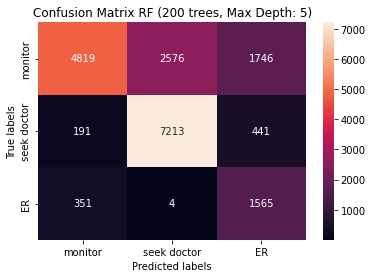

In [0]:
## Making the Confusion Matric Pretty
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix RF (200 trees, Max Depth: 5)'); 
ax.xaxis.set_ticklabels(['monitor', 'seek doctor', 'ER']); ax.yaxis.set_ticklabels(['monitor', 'seek doctor', 'ER']);

### Model 2a

In [0]:
## Using a random forest with only 20 trees, but each having a max depth of 10
rf2 = RandomForestClassifier(labelCol="label_num", featuresCol="features_norm", weightCol = 'weight', numTrees=20, maxDepth = 10)

In [0]:
## Second pipeline
pipeline_rf2 = Pipeline(stages=[string_sentiment,
                               string_gentopic,
                               string_label, 
                               onehot_sentiment, 
                               onehot_gentopic, 
                               vectorAssembler_features, 
                               normalizer,
                               rf2, 
                               labelConverter])

In [0]:
# Fitting the pipeline to the train data
model_rf2 = pipeline_rf2.fit(train_data)

#### Results

In [0]:
predictionsrf2 = model_rf2.transform(test_data)
accuracyrf2 = evaluator.evaluate(predictionsrf2)

In [0]:
print("Accuracy = %g" % accuracyrf2)
print("Test Error = %g" % (1.0 - accuracyrf2))

Accuracy = 0.722998
Test Error = 0.277002


In [0]:
predictions_train_rf2 = model_rf2.transform(train_data)
accuracy_train_rf2 = evaluator.evaluate(predictions_train_rf2)

In [0]:
print("Accuracy = %g" % accuracy_train_rf2)
print("Train Error = %g" % (1.0 - accuracy_train_rf2))

Accuracy = 0.71941
Train Error = 0.28059


In [0]:
y_pred_rf2 = predictionsrf2.select("prediction").collect()
y_orig_rf2 = predictionsrf2.select("label_num").collect()
cm_rf2 = confusion_matrix(y_orig_rf2, y_pred_rf2)
print("Confusion Matrix:")
print(cm_rf2)

Confusion Matrix:
[[4900 2570 1671]
 [ 202 7213  430]
 [ 360    4 1556]]


#### Table 1

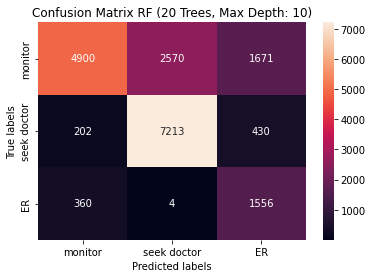

In [0]:
ax= plt.subplot()
sns.heatmap(cm_rf2, annot=True, fmt='g', ax=ax); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix RF (20 Trees, Max Depth: 10)'); 
ax.xaxis.set_ticklabels(['monitor', 'seek doctor', 'ER']); ax.yaxis.set_ticklabels(['monitor', 'seek doctor', 'ER']);
plt.savefig(os.path.join(PLOT_DIR, 'RF_cm.jpg'))
plt.show()

### Demonstrating ability to save and load model with no Additional Training

In [0]:
## Writing trained model to dbfs
model_rf2.save("/FileStore/RandomForestModel3")

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-2999732341301889> in <cell line: 2>()
      1 ## Writing trained model to dbfs
----> 2 model_rf2.save("/FileStore/RandomForestModel3")

/databricks/spark/python/pyspark/ml/util.py in save(self, path)
    337     def save(self, path: str) -> None:
    338         """Save this ML instance to the given path, a shortcut of 'write().save(path)'."""
--> 339         self.write().save(path)
    340 
    341 

/databricks/spark/python/pyspark/ml/util.py in save(self, path)
    288         if not isinstance(path, str):
    289             raise TypeError("path should be a string, got type %s" % type(path))
--> 290         self._jwrite.save(path)
    291 
    292     def overwrite(self) -> "JavaMLWriter":

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = sel

In [0]:
## Loading model from DBFS
model = PipelineModel.load("/FileStore/RandomForestModel3")

In [0]:
predictions_load = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction", metricName="accuracy")
acc_load = evaluator.evaluate(predictions_load)
print("Accuracy = %g" % acc_load)

Accuracy = 0.723262


In [0]:
predictions_load.groupBy('prediction').agg(
                                        f.avg('sentiment_num').alias('Average Sentiment'),
                                        f.avg('length').alias('Average Length'),
                                        f.count('prediction').alias('Count')).toPandas().rename(columns={'prediction':'Predicted Labels'})


,Predicted Labels,Average Sentiment,Average Length,Count
0,0.0,0.314317,836.793564,5469
1,1.0,0.349443,745.465413,9787
2,2.0,0.177260,625.611781,3650


In [0]:
predictions_load.groupBy('label').agg(
                                        f.avg('sentiment_num').alias('Average Sentiment'),
                                        f.avg('length').alias('Average Length'),
                                        f.count('prediction').alias('Count')).toPandas().rename(columns={'label':'Label'})

,Label,Average Sentiment,Average Length,Count
0,monitor,0.261788,728.041352,9141
1,seek doctor,0.385723,778.862970,7845
2,ER,0.191146,724.255729,1920


### Comparing Models

#### Plot 1

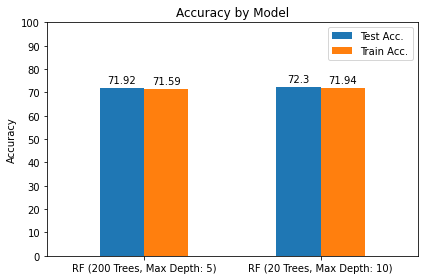

In [0]:
## GROUPED BOXPLOT SHOWING MODEL PERFORMANCE
labels = ['RF (200 Trees, Max Depth: 5)', 'RF (20 Trees, Max Depth: 10)']
test_acc = [round(100*accuracy, 2), round(100*accuracyrf2, 2)]
train_acc = [round(100 * accuracy_train, 2), round(100 * accuracy_train_rf2, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_acc, width, label='Test Acc.')
rects2 = ax.bar(x + width/2, train_acc, width, label='Train Acc.')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.set_xticks(x)
ax.set_yticks(np.arange(0,110, 10))
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.margins(x = .2)

fig.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, 'RF_model_acc_comp.jpg'))

plt.show()

## Analysis 2 - Estimating Similarity Among Reproductive Rights Groups

In [0]:
## Reading in RR sentiment data and adding length column
sentiment_df = spark.read.parquet('/FileStore/sentiment_rr_v2')
sentiment_df = sentiment_df.withColumnRenamed("col","sentiment")
sentiment_df = sentiment_df.withColumn("length", f.length(col('body')))

In [0]:
# Help with code: https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

#sentiment_df.printSchema()
sentiment_df=sentiment_df.na.drop()

In [0]:
# The attributes that we will use must be numerical or discrete numeric....
dataset = sentiment_df.select("subreddit", 'Abortion', 'Guns', 'Religion', 'Politics', 'Democrat', 'Republican', 'RoeVWade', "Length", "sentiment")

# Turn subreddit into 0=ProLife, 1=RoeVsWade, 2=ProChoice
dataset = dataset.withColumn('subreddit',
    f.when((f.col("subreddit") == 'prolife'), 0)\
    .when((f.col("subreddit") == 'roevwade2022'), 1)\
    .when((f.col("subreddit") == 'prochoice'), 2)\
)

# Turn boolean columns in 0 and 1
dataset = dataset.withColumn("Abortion", dataset.Abortion.cast('integer'))
dataset = dataset.withColumn("Guns", dataset.Guns.cast('integer'))
dataset = dataset.withColumn("Religion", dataset.Religion.cast('integer'))
dataset = dataset.withColumn("Politics", dataset.Politics.cast('integer'))
dataset = dataset.withColumn("Democrat", dataset.Democrat.cast('integer'))
dataset = dataset.withColumn("Republican", dataset.Republican.cast('integer'))
dataset = dataset.withColumn("RoeVWade", dataset.RoeVWade.cast('integer'))

# Turn sentiment into 0=Negative, 1=Neutral, 2=Positive
dataset = dataset.withColumn('sentiment',
    f.when((f.col("sentiment") == 'negative'), 0)\
    .when((f.col("sentiment") == 'neutral'), 1)\
    .when((f.col("sentiment") == 'positive'), 2)\
)

dataset.printSchema()

root
 |-- subreddit: integer (nullable = true)
 |-- Abortion: integer (nullable = true)
 |-- Guns: integer (nullable = true)
 |-- Religion: integer (nullable = true)
 |-- Politics: integer (nullable = true)
 |-- Democrat: integer (nullable = true)
 |-- Republican: integer (nullable = true)
 |-- RoeVWade: integer (nullable = true)
 |-- Length: integer (nullable = true)
 |-- sentiment: integer (nullable = true)



In [0]:
from pyspark.ml.feature import VectorAssembler

# Numerical attributes only...
# All attributes under consideration are numerical or discrete numeric, hence we need to convert them into features using a Vector Assembler.
assemble=VectorAssembler(inputCols=[
#    'subreddit', # This is the label/ cluster we would imagine that would appear...
    'Abortion',
    'Guns',
    'Religion',
    'Politics',
    'Democrat',
    'Republican',
    'RoeVWade',
    'sentiment',
    'Length'
 ], outputCol='features')

assembled_data=assemble.transform(dataset)
#assembled_data.show(2)

In [0]:
# Now that all columns are transformed into a single feature vector we need to standardize the data to bring 
# them to a comparable scale. IE Standardize the scale of each vector
from pyspark.ml.feature import StandardScaler
scale = StandardScaler(inputCol='features', outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
#data_scale_output.show(2)

# Now that our data is standardized we can develop the K Means algorithm....

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
min_k = 2
max_k = 10
for i in range(min_k, max_k):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)

    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score K=", str(i), ":",score)

Silhouette Score K= 2 : 0.23788077105933012
Silhouette Score K= 3 : 0.4655607409302995
Silhouette Score K= 4 : 0.30867659149477333
Silhouette Score K= 5 : 0.4009229011461074
Silhouette Score K= 6 : 0.43866840836291504
Silhouette Score K= 7 : 0.49986540846427124
Silhouette Score K= 8 : 0.5516657026953677
Silhouette Score K= 9 : 0.6540149104646035


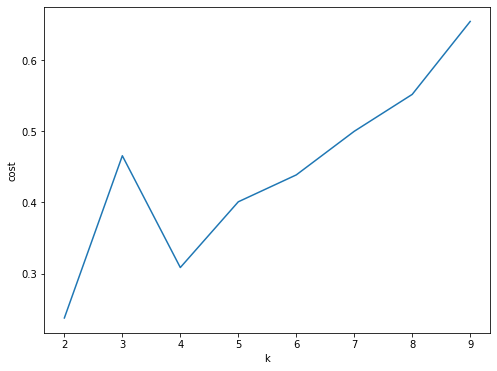

In [0]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(min_k, max_k),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.savefig(os.path.join(PLOT_DIR, 'SilhouetteScore.jpg'))


We expected to see a peak at 2 or 3 clusters but the silhouette method suggested 5 clusters. 

We will run with 3 clusters because that is what we want to predict.

In [0]:
# Help with code: https://www.analyticsvidhya.com/blog/2022/07/introduction-to-k-means-clustering-using-mlib/

# When clusters = 3
clusters = 3
kmeans_3_cluster = KMeans().setK( clusters ).setSeed(1)

# Fit our data
first_model = kmeans_3_cluster.fit(data_scale_output)

# Make cluster predictions
predictions_first_model = first_model.transform(data_scale_output)
# predictions_first_model.show(3)

# For each predicted cluster...
for pred_cluster in range (clusters):
    # Find the average subreddit label
    pass
    # Find the mode subbreddit label
    
    # Find total reddits classified as this cluster label
 
predictions_first_model = predictions_first_model.withColumn("RoeVWade", predictions_first_model.Religion.cast('integer'))
result = predictions_first_model.groupBy("prediction").agg(count("subreddit"), mean("subreddit"))
result.toPandas()

,prediction,count(subreddit),avg(subreddit)
0,1,723795,0.415517
1,2,15655,0.301948
2,0,74065,0.321974


The above shows that the predicted each of the 3 clusters has an average subreddit label of 0.3 or 0.4. This means that the most occuring label in all the clusters in 0. (We can see this by checking the mode. See below.) This reveals/enforces two important things about our data:

There are a lot more pro-life posts than posts on any other subreddit (we also saw this with our inital EDA. The prolife subreddit had at least twice as many posts as the other 2 subreddits.)
The clusters are not separated across subreddits because if they were, we would expect to see each cluster have each subreddit as it's mode/average.
We can then say that unsupervised learning failed to accurately detect the clusters we would have expected ro see.

In [0]:
counts = predictions_first_model.groupBy(['prediction', 'subreddit']).count().alias('counts')
result2 = (counts
          .groupBy('prediction')
          .agg(f.max(f.struct(f.col('count'),
                              f.col('subreddit'))).alias('max'))
          .select(f.col('prediction'), f.col('max.subreddit'))
         )
result2.toPandas()

,prediction,subreddit
0,1,0
1,2,0
2,0,0


### Model 2b –

In [0]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

# `dataset` is the variable that contains the information for the model
# dataset.show(5)

# convert to binary
dataset_2b = dataset.where(dataset.subreddit != 1) # remove roevwade
df_2=dataset_2b.withColumn("subreddit", when(dataset_2b.subreddit == 2, 1).otherwise(dataset_2b.subreddit))
df_2.show(5)

+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
|subreddit|Abortion|Guns|Religion|Politics|Democrat|Republican|RoeVWade|Length|sentiment|
+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
|        0|       0|   0|       0|       0|       0|         0|       0|     9|        0|
|        0|       1|   0|       1|       1|       0|         0|       0|   400|        0|
|        0|       1|   0|       0|       0|       0|         0|       0|    49|        0|
|        0|       0|   0|       1|       1|       0|         0|       0|  3332|        2|
|        0|       0|   0|       1|       1|       0|         0|       0|  3332|        2|
+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
only showing top 5 rows



In [0]:
# Split the data into training and test sets (30% held out for testing)
(trainingData_2b, testData_2b) = df_2.randomSplit([0.7, 0.3])


In [0]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col

trainingData_2b.show(5) # what does the trainingData look like

+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
|subreddit|Abortion|Guns|Religion|Politics|Democrat|Republican|RoeVWade|Length|sentiment|
+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
|        0|       0|   0|       0|       0|       0|         0|       0|     1|        0|
|        0|       0|   0|       0|       0|       0|         0|       0|     1|        1|
|        0|       0|   0|       0|       0|       0|         0|       0|     1|        1|
|        0|       0|   0|       0|       0|       0|         0|       0|     1|        1|
|        0|       0|   0|       0|       0|       0|         0|       0|     1|        1|
+---------+--------+----+--------+--------+--------+----------+--------+------+---------+
only showing top 5 rows



In [0]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Can they be identified as Democrat or Republican??
# 1 if Democrat, 0 if Republican

# Train a GradientBoostedTrees model.
#  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
#         (b) Use more iterations in practice.

labelConverter_2b = IndexToString(inputCol="subreddit", 
                               outputCol="subreddit_string", 
                               labels= ['0', '2'])

vectorAssembler_features_2b = VectorAssembler(
    inputCols=['Abortion', 'Guns', 'Religion', 'Politics', 'Democrat', 'Republican', 'RoeVWade', 'Length', 'sentiment'], # remove Democrat because that will be the label
    outputCol= 'features')
    
# string_label_2b.fit(testData_2b).transform(testData_2b).show()

gb = GBTClassifier(labelCol = 'subreddit', featuresCol = 'features', maxDepth= 5, maxIter = 20)


pipeline_gb = Pipeline(stages=[#string_sentiment,
                               #string_gentopic,
                               # string_label_2b, 
                               #onehot_sentiment, 
                               #onehot_gentopic, 
                               vectorAssembler_features_2b, 
                               # normalizer,
                               gb, 
                               labelConverter_2b])

model_gb = pipeline_gb.fit(trainingData_2b)

In [0]:
## Generating predictions and accuracy
predictions_2b = model_gb.transform(testData_2b)

evaluator_2b = MulticlassClassificationEvaluator(labelCol="subreddit", predictionCol="prediction", metricName="accuracy")

accuracy_2b = evaluator_2b.evaluate(predictions_2b)

print('The accuracy of the gradient boosting algorithm is:', accuracy_2b)

y_pred_2b = predictions_2b.select("prediction").collect()

y_orig_2b = predictions_2b.select("subreddit").collect()

cm_2b = confusion_matrix(y_orig_2b, y_pred_2b)

print("Confusion Matrix:")

print(cm_2b)


The accuracy of the gradient boosting algorithm is: 0.7999348053030522
Confusion Matrix:
[[193706     99]
 [ 48387    159]]


Out[147]: [Text(0, 0.5, 'prolife'), Text(0, 1.5, 'prochoice')]

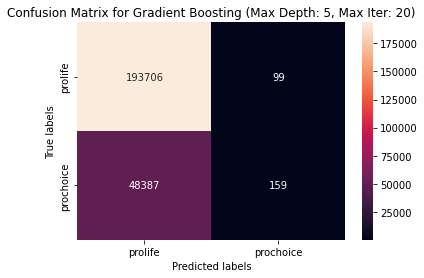

In [0]:
# Creating confusion matrix
ax= plt.subplot()
sns.heatmap(cm_2b, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Gradient Boosting (Max Depth: 5, Max Iter: 20)'); 
ax.xaxis.set_ticklabels(['prolife', 'prochoice']); ax.yaxis.set_ticklabels(['prolife', 'prochoice'])

In [0]:
# save plot
plt.savefig(os.path.join(PLOT_DIR, 'GB_cm.jpg'))

<Figure size 432x288 with 0 Axes>